In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import random
import copy

from collections import Counter, defaultdict
from deap import base, creator, tools
from tqdm import tqdm

In [2]:
threshold = 0.3 #threshold di discriminazione
egoradius = 2 #Per link da aggiungere - raggio dell'egonetwork
delete = 0.5 #Per link da eliminare - top % con betweeness bassa rimovibili
attr_name = 'gender'

In [3]:
# 0 = Solo aggiunta
# 1 = Solo rimozione
# 2 = Entrambe
mode = 2

# AMARE - Attribute-aware MARginalization Estimator

In [4]:
g = nx.Graph()
g.name = 'copenhagen'
with open('bt_symmetric.csv') as f:
    for l in f.readlines()[1:]:
        tid, a, b, rssi = l.rstrip().split(',')
        g.add_edge(int(a),int(b), tid=tid)
print('loaded net')

attrs = {n: None for n in g.nodes()} # also fix missing data
with open('genders.csv') as f:
    for l in f.readlines()[1:]:
        node, gender = l.rstrip().split(',')
        attrs[int(node)] = gender
    nx.set_node_attributes(g, attrs, name=attr_name)
print('loaded attributes')

to_remove = []
for n in attrs:
    if attrs[n] is None:
        to_remove.append(n)

g.remove_nodes_from(to_remove)
print('unlabeled removed')

loaded net
loaded attributes
unlabeled removed


In [5]:
print(nx.info(g))

Name: copenhagen
Type: Graph
Number of nodes: 673
Number of edges: 75124
Average degree: 223.2511


In [6]:
attrs = nx.get_node_attributes(g, attr_name)

In [7]:
#g = nx.convert_node_labels_to_integers(g)
sizes = dict(Counter(list(attrs.values())))
sizes['0'] = sizes['0'] / (len(g))
sizes['1'] = sizes['1'] / (len(g))
weights = dict(Counter(list(attrs.values())))
weights['0'] = 1 - sizes['0']
weights['1'] = 1 - sizes['1']

In [8]:
marg_dict = dict()

for node in tqdm(g.nodes()):
    attr = attrs[node]
    
    # COMPUTE MARGINALIZATION
    marg = 0
    egonet = list(g.neighbors(node)) + [node]
    egonet_attrs = [attrs[n] for n in egonet]
    
    count = dict(Counter(egonet_attrs))[attr]
    size = len(egonet_attrs)
    
    if size > 2:
        marg = ((count * weights[attr] / (count * weights[attr] + (size-count)* (1 - weights[attr]))) - 0.5) * 2
    else:
        marg = 0
    
    marg_dict[node] = marg

disc_nodes = [k for k,v in marg_dict.items() if abs(v) > threshold]
disc = len(disc_nodes)

100%|██████████| 673/673 [00:00<00:00, 42372.43it/s]


=== STATS ===
Marginalized nodes: 42
Global Discrimination: 6.240713224368499
Overall Marginalization Score: 0.1129377217024731


<AxesSubplot:ylabel='Density'>

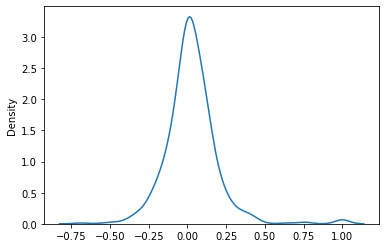

In [9]:
print("=== STATS ===")
print("Marginalized nodes:", disc)
print("Global Discrimination:", disc * 100 / len(g.nodes()))
print("Overall Marginalization Score:", np.mean([abs(x) for x in marg_dict.values()]))
sns.kdeplot(list(marg_dict.values()))

In [10]:
if mode == 1:
    possible_links = []
else:
    plausible = nx.Graph() # stores plausible links

    for node in tqdm(disc_nodes):
        egonet = list(g.neighbors(node)) + [node]
        egonet2 = nx.ego_graph(g, node, center=True, radius=egoradius)
        egonet2.remove_nodes_from(egonet)
        for n in egonet2.nodes():
            if node != n and n in disc_nodes:
                if marg_dict[node] > 0:
                    if attrs[n] != attrs[node]:
                        plausible.add_edge(node, n)
                elif marg_dict[node] < 0:
                    if attrs[n] == attrs[node]:
                        plausible.add_edge(node, n)         
                else:
                    print("ERROR #1")

    possible_links = list(plausible.edges())

100%|██████████| 42/42 [00:09<00:00,  4.32it/s]


In [11]:
if mode == 0:
    weak_links = []
else:
    #Betweenness centrality su archi
    betweenness = nx.edge_betweenness_centrality(g) #dizionario di archi con score di B/W centrality

    marg_betweenness = dict()
    for k, v in betweenness.items():
        if k[0] in disc_nodes and k[1] in disc_nodes:
            if marg_dict[k[0]] > 0:
                if attrs[k[0]] == attrs[k[1]]:
                    marg_betweenness[k] = v
            elif marg_dict[k[0]] < 0:
                if attrs[k[0]] != attrs[k[1]]:
                    marg_betweenness[k] = v
            else:
                print ("ERROR #02")

    marg_betweenness = dict(sorted(marg_betweenness.items(), key=lambda item: item[1]))
    weak_links = list(marg_betweenness.keys())[:round(len(marg_betweenness) * delete)]

In [12]:
links = possible_links + weak_links #tutti i links con cui il GA opera

# MARK - MArginalization Reducer using linK

In [13]:
def random_individual(links):
    individual = []
    for e in links:
        individual.append(random.randint(0,1)) #1 = aggiunto/rimosso; 0 = do nothing
    return individual 

In [14]:
def evaluate(individual, g):
    individual = individual[0] #<- because DEAP
    score = 0
    eva_g = copy.deepcopy(g)
    indexes = [i for i, j in enumerate(individual) if j == 1]
    new_links = [links[i] for i in indexes]

    for l in new_links:
        if l in possible_links:
            eva_g.add_edge(l[0], l[1])
        elif l in weak_links:
            eva_g.remove_edge(l[0], l[1])
            
    for node in disc_nodes:
        marg = 0
        egonet = list(eva_g.neighbors(node)) + [node]
        egonet_attrs = [attrs[n] for n in egonet]
        count = dict(Counter(egonet_attrs))[attr]
        size = len(egonet)
        if size > 2:
            marg = ((count * weights[attr] / (count * weights[attr] + (size-count)* (1 - weights[attr]))) - 0.5) * 2
            if abs(marg) > threshold:
                score += 1
        
    budget = sum(individual)
            
    return score, budget

    #Fitness 1: nodi marginalizzati rimasti
    #Fitness 2: link usati
    
    #A parità di nodi marginalizzati (il meno possibile), la soluzione con meno link usati è la migliore

In [15]:
creator.create("Fitness", base.Fitness, weights=(-1.0,-1.0)) # <- -1 perché vogliamo minimizzare la fitness
creator.create("Individual", list, fitness=creator.Fitness) #<- l'individuo è definito come lista

toolbox = base.Toolbox() #creiamo il toolbox

toolbox.register("random_individual", random_individual, links) 
#"nome_della_funzione per deap", nome_della_funzione vera e propria di python, parametri che passi alla funzione

toolbox.register("individual", tools.initRepeat, creator.Individual, 
                 toolbox.random_individual, n=1) 
# n = numero di individui nella popolazione. Lasciamo 1

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate, g=g) #funzione di valutazione. Vedi quanto detto sopra
toolbox.register("mate", tools.cxTwoPoint) #funzione di crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05) #funzione di mutazione custom
toolbox.register("select", tools.selTournament, tournsize=3)
#tools.selNSGA2) #funzione di selezione

Marginalized nodes: 42 · Available links: 484
gen	nevals	min	avg    
0  	150   	11 	16.7467
1  	89    	11 	15.2267
2  	78    	11 	14.04  
3  	107   	11 	13.6   
4  	103   	10 	13.14  
5  	101   	9  	12.72  
6  	94    	8  	12.2267
7  	98    	8  	11.6667
8  	100   	8  	11.3667
9  	90    	8  	10.76  
10 	84    	7  	10.0067
11 	99    	6  	9.50667
12 	103   	6  	9.01333
13 	106   	5  	8.65333
14 	100   	5  	8.20667
15 	95    	5  	7.84667
16 	91    	5  	7.2    
17 	85    	5  	6.73333
18 	103   	5  	6.44   
19 	96    	5  	6.26   
20 	91    	5  	5.96667
21 	87    	5  	5.84   
22 	98    	5  	5.76   
23 	85    	5  	5.8    
24 	90    	5  	5.78667
25 	90    	5  	5.69333
26 	83    	5  	5.77333
27 	101   	4  	5.88   
28 	94    	4  	5.70667
29 	92    	4  	5.76   
30 	98    	4  	5.76667
31 	98    	4  	5.95333
32 	92    	4  	5.81333
33 	101   	4  	5.62   
34 	99    	4  	5.56667
35 	86    	4  	5.46   
36 	108   	4  	5.57333
37 	94    	4  	5.22667
38 	94    	4  	5.12   
39 	93    	4  	5.24667
40 	94    	

<Figure size 432x288 with 0 Axes>

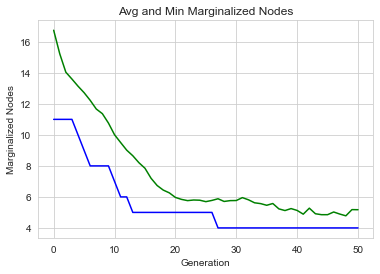

In [16]:
print('Marginalized nodes:', disc, '· Available links:', len(links))
NUM_GENERATIONS = 50 #numero di generazioni
POPULATION_SIZE = 150 #popolazione per gen

CXPB, MUTPB = 0.5, 0.25 #crossover e mutation probability

n_HOF = 10 #top soluzioni da ritornare (la "Hall of Fame" di DEAP è il set di tutte le top n soluzioni)

pop = toolbox.population(n=POPULATION_SIZE)

hof = tools.HallOfFame(n_HOF)

stats = tools.Statistics(lambda ind: ind.fitness.values[0])   
stats.register('min', np.min, axis = 0)
stats.register('avg', np.mean, axis = 0)

logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + stats.fields

invalid_individuals = [ind for ind in pop if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_individuals)
for ind, fit in zip(invalid_individuals, fitnesses):
    ind.fitness.values = fit

hof.update(pop)
hof_size = len(hof.items)

record = stats.compile(pop)
logbook.record(gen=0, best="-", nevals=len(invalid_individuals), **record)
print(logbook.stream)

for gen in range(1, NUM_GENERATIONS + 1):

            # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))


    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1[0], child2[0])
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant[0])
            del mutant.fitness.values


    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Update the hall of fame with the generated individuals
    hof.update(offspring)

    # Replace the current population by the offspring
    pop[:] = offspring

    # Append the current generation statistics to the logbook
    record = stats.compile(pop) if stats else {}
    logbook.record(gen=gen, nevals=len(invalid_ind), **record)
    print(logbook.stream)


hof.update(pop) # la HoF è aggiornata con la nuova popolazione (o meglio, i suoi individui migliori w.r.t. fitness)

plt.figure(1)

minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
plt.figure(2)
sns.set_style("whitegrid")
#plt.plot(maxFitnessValues, color='red')
plt.plot(minFitnessValues, color='blue')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Marginalized Nodes')
plt.title('Avg and Min Marginalized Nodes')
# show both plots:
plt.show()


#return hof.items

In [39]:
for e in hof.items[:3]:
    print('Marginalized nodes:', e.fitness.values[0], '· Links:', e.fitness.values[1], '· Percentage:', e.fitness.values[1]/g.number_of_edges())
    print(e[0])
    print()

Marginalized nodes: 4.0 · Links: 228.0 · Percentage: 0.003034982162824131
[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0

In [18]:
#best = hof.items[0][0]
#index = [i for i, j in enumerate(best) if j == 1]
#new_links = [links[i] for i in index]

#new_links

In [19]:

rans = []
c = 0
print("Marginalized nodes:", end = ' ')
while c < 100:
    ran = random_individual(links)
    print(evaluate([ran], g)[0], end = ' ')
    rans.append(evaluate([ran], g)[0])
    c = c+1
print()
print()
print("Avg:", np.mean(rans), "· Min:", min(rans))

Marginalized nodes: 18 13 14 16 16 15 16 16 18 12 19 17 16 16 19 16 19 20 19 17 15 20 13 19 18 16 18 15 17 18 20 14 18 17 18 14 15 16 17 16 17 16 18 19 15 15 17 16 16 17 17 19 17 13 20 18 16 18 17 18 17 16 16 13 17 17 18 19 19 16 17 17 16 17 16 16 14 14 15 14 15 17 16 18 14 20 21 17 17 17 16 18 16 16 18 16 19 14 21 16 

Avg: 16.71 · Min: 12
